## create synthetic data based on original data

In [1]:
suppressWarnings(suppressMessages(library(synthpop)))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(caret)))
suppressWarnings(suppressMessages(library(mlr)))
suppressWarnings(suppressMessages(library(boot)))

In [2]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRblas.0.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.2/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] boot_1.3-28         mlr_2.19.1          ParamHelpers_1.14.1
 [4] caret_6.0-93        lattice_0.20-45     forcats_0.5.2      
 [7] stringr_1.4.1       dplyr_1.0.10        purrr_0.3.4        
[10] readr_2.1.3         tidyr_1.2.1         tibble_3.1.8       
[13] ggplot2_3.3.6       tidyverse_1.3.2     synthpop_1.8-0     

loaded via a namespace (and not attached):
  [1] TH.data_1.1-1        googledrive_2.0.0    colorspace_2.0-3    
  [4] ellipsis_0.3.2       class_7.3-20         modeltool

In [3]:
setwd('/Users/jeremyzyang/Library/CloudStorage/Dropbox-Personal/research/surrogate/log')

In [4]:
df1 = read.csv('./df_exp1.csv') # load data with pre-treatment covariates
df1_s = read.csv('./df_surrogate_exp1.csv') # load data with surrogates and outcomes

df1 = arrange(df1, subscriber_id)
df1_s = arrange(df1_s, subscriber_id)

df1 = left_join(df1, df1_s %>%
                select(subscriber_id, rev_1, rev_2, rev_3, rev_4, rev_5, rev_6), by = 'subscriber_id')

In [5]:
mu_6 = read.csv('./mu_18m_6.csv')
mu_5 = read.csv('./mu_18m_5.csv')
mu_4 = read.csv('./mu_18m_4.csv')
mu_3 = read.csv('./mu_18m_3.csv')
mu_2 = read.csv('./mu_18m_2.csv')
mu_1 = read.csv('./mu_18m_1.csv')

mu_6 = rename(mu_6, y0_6 = y0, y1_6 = y1)
mu_5 = rename(mu_5, y0_5 = y0, y1_5 = y1)
mu_4 = rename(mu_4, y0_4 = y0, y1_4 = y1)
mu_3 = rename(mu_3, y0_3 = y0, y1_3 = y1)
mu_2 = rename(mu_2, y0_2 = y0, y1_2 = y1)
mu_1 = rename(mu_1, y0_1 = y0, y1_1 = y1)

set.seed(100) # select a subset of features and randomly sample 1000 users to speed up the generation of synthetic data
n = 1000

df1_sample = df1 %>% select(rev_1, rev_2, rev_3, rev_4, rev_5, rev_6,
                            subscriber_id, risk_score, p_treated, treated, contains('month')) %>% sample_n(n)

df1_sample = left_join(df1_sample, mu_6, by = 'subscriber_id')
df1_sample = left_join(df1_sample, mu_5, by = 'subscriber_id')
df1_sample = left_join(df1_sample, mu_4, by = 'subscriber_id')
df1_sample = left_join(df1_sample, mu_3, by = 'subscriber_id')
df1_sample = left_join(df1_sample, mu_2, by = 'subscriber_id')
df1_sample = left_join(df1_sample, mu_1, by = 'subscriber_id')

In [6]:
capture.output(
        df1_syn <- syn(df1_sample %>% # create the synthetic data that preserves the correlation structure in the original dataset
                   select(-subscriber_id, -treated, -p_treated),
                   seed = 100)$syn,
        file = '/dev/null'
    )

In [7]:
df1_syn$subscriber_id = df1_sample$subscriber_id
df1_syn$treated = df1_sample$treated
df1_syn$p_treated = df1_sample$p_treated

In [8]:
write.csv(df1_syn %>% select(-subscriber_id), 'synthetic.csv', row.names = F)

## optimize policies on synthetic data

In [9]:
# convert covariates into model matrix for prediction
df_X = select(df1_syn, -subscriber_id, -treated, -p_treated, -contains('y0'), -contains('y1'), -contains('rev'))
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

In [10]:
# split training and test data, test data will be used in policy evaluation
set.seed(101)
train_id = sort(sample(nrow(df_X), nrow(df_X)*0.8))

In [11]:
# policy optimization
optimize_binary_policy <- function(
                            mu, # load data with pre-treatment covariates, surrogates, predicted outcomes and imputed outcomes
                            id, # id to match the data with
                            outcome, # specify which outcome to use to optimize the policy 
                            train_id){ # vector of row numbers used in training 
                                   
mu = arrange(mu, id)    
mu = rename(mu,rev = all_of(outcome))

# construct doubly robust scores
mu$y0_dr = ifelse(mu$treated == 1, mu$y0, mu$y0 + (mu$rev - mu$y0)/(1-mu$p_treated))
mu$y1_dr = ifelse(mu$treated == 0, mu$y1, mu$y1 + (mu$rev - mu$y1)/(mu$p_treated))
mu$tau_dr = mu$y1_dr - mu$y0_dr
    
# construct misclassification cost
cost = data.frame(control = rep(0,nrow(mu)), treat = rep(0,nrow(mu)))
cost$control = ifelse(mu$tau_dr < 0,0,abs(mu$tau_dr))
cost$treat = ifelse(mu$tau_dr > 0,0,abs(mu$tau_dr))

# convert covariates into model matrix
df_X = select(mu, -subscriber_id, -treated, -p_treated, -contains('y0'), -contains('y1'), -contains('rev'), -contains('dr'))
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

# specify cost-sensitive classifier
obp = makeCostSensTask(id = "binary-action policy learning", 
                       data = df_X[train_id,], 
                       cost = cost[train_id,])

# specify learner with pre-tuned hyperparameters 
learner = makeLearner("classif.xgboost",
                      predict.type = "prob",
                      eval_metric = 'logloss',
                      eta = 0.3,
                      max_depth = 6,
                      gamma = 0,
                      colsample_bytree = 0.6,
                      min_child_weight = 1,
                      subsample = 1,
                      nrounds = 150)
learner = makeCostSensWeightedPairsWrapper(learner)

# train the classifier
obp = mlr::train(learner, obp)

return(obp)

}

In [12]:
df_6 = rename(df1_syn, y0 = y0_6, y1 = y1_6)
obp_6 = optimize_binary_policy(df_6, 'subscriber_id', 'rev_6', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 6 months

df_5 = rename(df1_syn, y0 = y0_5, y1 = y1_5)
obp_5 = optimize_binary_policy(df_5, 'subscriber_id', 'rev_5', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 5 months

df_4 = rename(df1_syn, y0 = y0_4, y1 = y1_4)
obp_4 = optimize_binary_policy(df_4, 'subscriber_id', 'rev_4', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 4 months

df_3 = rename(df1_syn, y0 = y0_3, y1 = y1_3)
obp_3 = optimize_binary_policy(df_3, 'subscriber_id', 'rev_6', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 3 months

df_2 = rename(df1_syn, y0 = y0_2, y1 = y1_2)
obp_2 = optimize_binary_policy(df_2, 'subscriber_id', 'rev_2', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 6 months

df_1 = rename(df1_syn, y0 = y0_1, y1 = y1_1)
obp_1 = optimize_binary_policy(df_1, 'subscriber_id', 'rev_1', train_id) # optimize policy with 18-month surrogate index constructed with surrogates in the first 1 month

## evaluate policies on synthetic data

In [13]:
# compare a policy with a benchmark policy that treats no one
policy_eval_benchmark <- function(test,indices) {
  
  test_b = test[indices,]

  test_b$p_no_one = ifelse(test_b$treated==1, 0, 1)
  test_b$p_design = ifelse(test_b$treated==1, test_b$p_treated, 1-test_b$p_treated)
    
  test_b$p_dr = ifelse(test_b$response == 'treat',test_b$treated,1-test_b$treated) 
  test_b$p_dr_treat <- ifelse(test_b$response == 'treat',1,0)
    
  rev_no_one = with(test_b, mean(y0 + 
                             p_no_one/p_design*(rev - (y1*treated + y0*(1-treated)))))   

  rev_dr = with(test_b, mean(y1*p_dr_treat + y0*(1-p_dr_treat) + 
                             p_dr/p_design*(rev - (y1*treated + y0*(1-treated)))))
  
  return(c(rev_dr - rev_no_one))
    
}

In [14]:
df_X = select(df1_syn, -subscriber_id, -treated, -p_treated, -contains('y0'), -contains('y1'), -contains('rev'))
df_X = model.matrix(~.-1, df_X) %>% as.data.frame
colnames(df_X) = paste0('col',seq(1,ncol(df_X)))

test_X = df_X[-train_id,]
test = cbind(test_X, df1_syn[-train_id,] %>%
            select(subscriber_id, treated, p_treated, contains('y0'), contains('y1'), contains('rev')))

In [15]:
test_6 = rename(test, rev = rev_6, y0 = y0_6, y1 = y1_6)

pred = predict(obp_6, newdata = test_6[,1:ncol(df_X)]) %>% as.data.frame
test_6$response = pred$response

ests_6 = boot::boot(data = test_6, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [16]:
test_5 = rename(test, rev = rev_5, y0 = y0_5, y1 = y1_5)

pred = predict(obp_5, newdata = test_5[,1:ncol(df_X)]) %>% as.data.frame
test_5$response = pred$response

ests_5 = boot::boot(data = test_5, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [17]:
test_4 = rename(test, rev = rev_4, y0 = y0_4, y1 = y1_4)

pred = predict(obp_4, newdata = test_4[,1:ncol(df_X)]) %>% as.data.frame
test_4$response = pred$response

ests_4 = boot::boot(data = test_4, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [18]:
test_3 = rename(test, rev = rev_3, y0 = y0_3, y1 = y1_3)

pred = predict(obp_3, newdata = test_3[,1:ncol(df_X)]) %>% as.data.frame
test_3$response = pred$response

ests_3 = boot::boot(data = test_3, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [19]:
test_2 = rename(test, rev = rev_2, y0 = y0_2, y1 = y1_2)

pred = predict(obp_2, newdata = test_2[,1:ncol(df_X)]) %>% as.data.frame
test_2$response = pred$response

ests_2 = boot::boot(data = test_2, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [20]:
test_1 = rename(test, rev = rev_1, y0 = y0_1, y1 = y1_1)

pred = predict(obp_1, newdata = test_1[,1:ncol(df_X)]) %>% as.data.frame
test_1$response = pred$response

ests_1 = boot::boot(data = test_1, 
                  statistic = policy_eval_benchmark,
                  R = 1000, 
                  parallel = "multicore",
                  ncpus = 4)

In [21]:
ests_1 = as.data.frame(ests_1$t)
ests_2 = as.data.frame(ests_2$t)
ests_3 = as.data.frame(ests_3$t)
ests_4 = as.data.frame(ests_4$t)
ests_5 = as.data.frame(ests_5$t)
ests_6 = as.data.frame(ests_6$t)

ests_1$time = 1
ests_2$time = 2
ests_3$time = 3
ests_4$time = 4
ests_5$time = 5
ests_6$time = 6

ests = rbind(ests_1, ests_2, ests_3, ests_4, ests_5, ests_6)

In [22]:
ests_plot = ests %>% group_by(time) %>% mutate(mean = mean(V1),
                                               ci_75_lower = quantile(V1, 0.075),
                                               ci_75_upper = quantile(V1, 0.925),
                                               ci_95_lower = quantile(V1, 0.025),
                                               ci_95_upper = quantile(V1, 0.975))

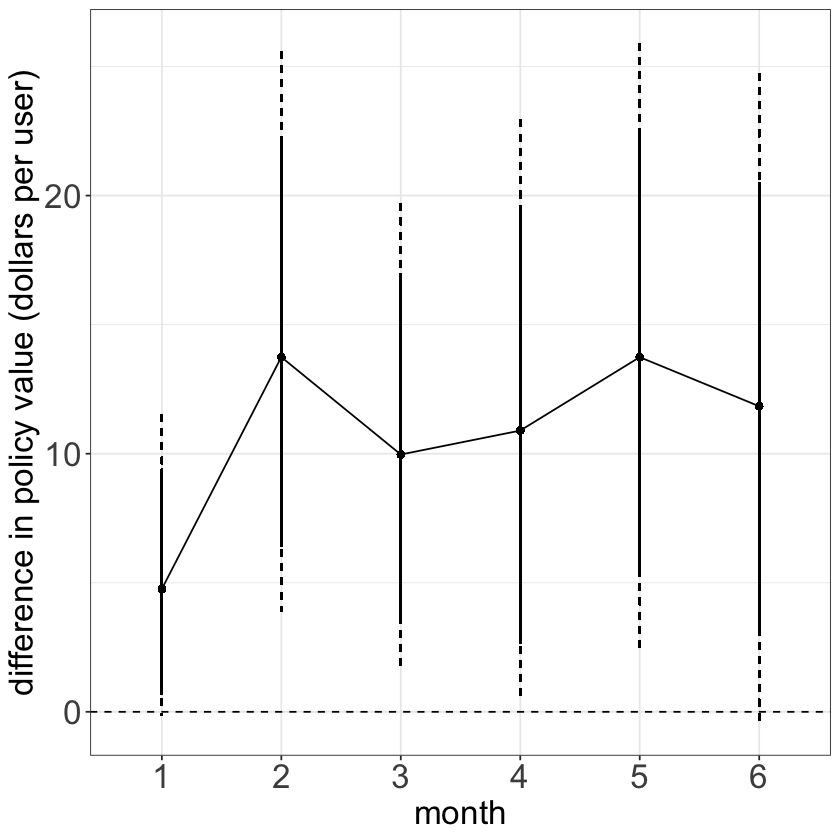

In [23]:
ggplot(ests_plot, aes(time,mean,group = 1)) + 
  geom_line() +
  geom_point() +
  geom_errorbar(aes(ymin=ci_95_lower, 
                    ymax=ci_95_upper), width=0, linetype = 'dashed') + 
  geom_errorbar(aes(ymin=ci_75_lower, 
                    ymax=ci_75_upper), width=0) + 
  theme_bw() + 
geom_hline(yintercept = 0, linetype = 'dashed') +
scale_x_discrete(limits = factor(c(1:6))) + 
scale_color_grey() +
xlab('month') + 
ylab('difference in policy value (dollars per user)') +
theme(axis.text = element_text(size = 20), axis.title = element_text(size = 20))   